In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
from PIL import Image
import open3d as o3d

import torch
from shapely.geometry import Polygon, Point

from lang_sam import LangSAM

In [2]:
import rerun as rr  # NOTE: `rerun`, not `rerun-sdk`!


In [3]:


def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()



def crop_point_cloud(point_cloud, mapping, masks):
    polygons = []
    for mask in masks:
        # Convert the PyTorch tensor to a numpy array
        if isinstance(mask, torch.Tensor):
            mask_np = mask.cpu().numpy()  # Ensure it's moved to CPU memory
        else:
            mask_np = mask
        
        # Ensure the mask is binary and find contours
        mask_binary = mask_np.astype(np.uint8)  # Convert to uint8
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for contour in contours:
            # Convert contour points to a suitable format for Polygon
            contour_points = contour.squeeze().tolist()
            if len(contour_points) > 2:  # Polygon needs at least 3 points
                polygons.append(Polygon(contour_points))

    h, w = mapping.shape[:2]
    points_inside = []

    # Iterate over the image
    for iy in range(h):
        for ix in range(w):
            point_index = mapping[iy, ix]
            if point_index != -1:
                # Map the 2D image coordinate to a 2D point (assuming XY plane)
                point_2d = Point(ix, iy)
                # Check if the 2D point is inside any of the polygons
                if any(polygon.contains(point_2d) for polygon in polygons):
                    points_inside.append(point_index)

    # Crop the point cloud to only include points inside the polygons
    cropped_point_cloud = point_cloud[points_inside]

    return cropped_point_cloud

def cloud_to_image_auto(pcd_np, image_width, image_height):
    # Calculate bounds of the point cloud
    min_coords = np.min(pcd_np[:, :2], axis=0)
    max_coords = np.max(pcd_np[:, :2], axis=0)

    # Calculate scaling factors for x and y axes
    scale_x = (image_width - 1) / (max_coords[0] - min_coords[0])
    scale_y = (image_height - 1) / (max_coords[1] - min_coords[1])

    # Initialize the image and mapping
    image = np.zeros((image_height, image_width, 3), dtype=np.uint8)
    mapping = np.full((image_height, image_width), -1, dtype=int)

    # Iterate over the point cloud and map each point to the image
    for i, point in enumerate(pcd_np):
        x, y, _, r, g, b = point

        # Scale and transform the coordinates
        pixel_x = int((x - min_coords[0]) * scale_x)
        pixel_y = image_height - 1 - int((y - min_coords[1]) * scale_y)

        # Place the point in the image and record the mapping
        image[pixel_y, pixel_x] = [r, g, b]
        mapping[pixel_y, pixel_x] = i

    return image, mapping

In [4]:

# scan_file_path = '/home/ybb/vs/drone-seg/lidar-scans/misc/gravel_two_pile.ply'
# scan_file_path = '/home/ybb/vs/drone-seg/lidar-scans/woodpils/pile_6_19_2023.ply'
# scan_file_path = '/home/ybb/vs/drone-seg/lidar-scans/woodpils/wp_pcam.ply'
# scan_file_path ='/home/ybb/vs/drone-seg/lidar-scans/woodpils/Wood Pile A.ply'
# scan_file_path = '/home/ybb/vs/drone-seg/lidar-scans/woodpils/Stump.ply'

# scan_file_path = '/home/ybb/vs/biomass-volume/assets/wood_piles/backyard_pile.ply'
scan_file_path = '/home/ybb/vs/biomass-volume/assets/wood_piles/wood_stack_1.ply'



pcd = o3d.io.read_point_cloud(scan_file_path)

o3d.visualization.draw_geometries([pcd])

In [5]:
pcd_pts = np.asarray(pcd.points)  
pcd_rgb = np.asarray(pcd.colors) * 255
pcd_np = np.hstack((pcd_pts, pcd_rgb))


# orthoimage, mapping = cloud_to_image_auto(pcd_np, 1080, 1080)
orthoimage, mapping = cloud_to_image_auto(pcd_np, 512, 512)
# orthoimage, mapping = cloud_to_image_auto(pcd_np, 256, 256)


ortho_height, ortho_width, channels = orthoimage.shape
print(ortho_height, ortho_width)   

512 512


/home/ybb/miniconda3/envs/biomass/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ybb/miniconda3/envs/biomass/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/ybb/miniconda3/envs/biomass/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/ybb/miniconda3/envs/biomass/lib/python3.9/site-packages/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings

final text_encoder_type: bert-base-uncased
Model loaded from /home/ybb/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


/home/ybb/miniconda3/envs/biomass/lib/python3.9/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/ybb/miniconda3/envs/biomass/lib/python3.9/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/ybb/miniconda3/envs/biomass/lib/python3.9/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


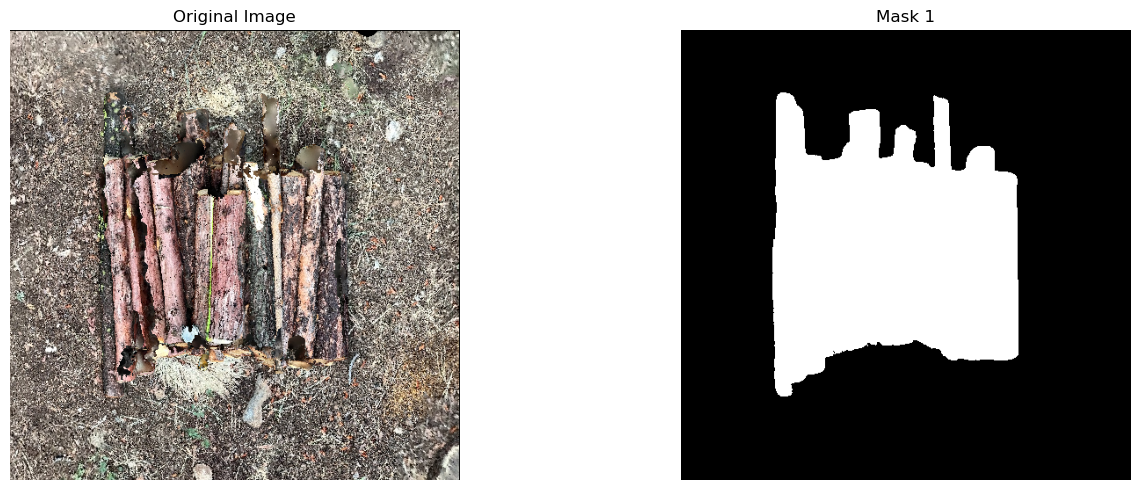

In [6]:

model = LangSAM()

orthoimage_pil = Image.fromarray(orthoimage)


text_prompt = "wood pile"
# text_prompt = "wood pile from above"
# text_prompt = "wood pile, tree stump, tree trunck"


masks, boxes, phrases, logits = model.predict(orthoimage_pil, text_prompt)

# Convert masks to numpy arrays
masks_np = [mask.squeeze().cpu().numpy() for mask in masks]

# Display the original image and masks side by side
display_image_with_masks(orthoimage, masks_np)

In [14]:
p = crop_point_cloud(pcd_np, mapping, masks)


pcd_crop_points = p[:, :3]
pcd_crop_colors = p[:, 3:]

if pcd_crop_colors.max() > 1:
    pcd_crop_colors = pcd_crop_colors / 255.0

crop_pcd = o3d.geometry.PointCloud()
crop_pcd.points = o3d.utility.Vector3dVector(pcd_crop_points)
crop_pcd.colors = o3d.utility.Vector3dVector(pcd_crop_colors)

# o3d.visualization.draw_geometries([crop_pcd])


In [15]:
hull, _ = crop_pcd.compute_convex_hull()
hull = hull.simplify_quadric_decimation(target_number_of_triangles=100) 
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
hull_ls.paint_uniform_color((1, 0, 0))
# o3d.visualization.draw_geometries([crop_pcd, hull_ls])

volume_m3 = hull.get_volume() 
print("Volume of the convex hull:", volume_m3) 

Volume of the convex hull: 0.8159040975391588


In [16]:
conversion_factor = 35.3147
volume_ft3 = volume_m3 * conversion_factor

print("Volume in cubic feet:", volume_ft3) 

Volume in cubic feet: 28.813408433366135


In [21]:
import copy


new_crop_pcd = copy.deepcopy(crop_pcd)

new_crop_pcd.translate((3,0,3))

hull_2 = copy.deepcopy(hull_ls)
hull_2.translate((-3,0,3))

LineSet with 150 lines.

In [22]:
o3d.visualization.draw_geometries([hull_2, pcd, new_crop_pcd])


In [23]:
vertices = np.asarray(hull_2.points)
lines = np.asarray(hull_2.lines)
hull_2_line_strips = []

for i in range(len(lines)):
    line_strip = [vertices[lines[i, 0]].tolist(), vertices[lines[i, 1]].tolist()]
    hull_2_line_strips.append(line_strip)

# Flatten the line strips list
hull_2_line_strips = [point for strip in hull_2_line_strips for point in strip]

In [ ]:
from collections import namedtuple

PointCloud = namedtuple("ColorGrid", ["positions", "colors"])


def PointCloudTuple(o3d_pcd):
    """Convert an Open3D PointCloud to a PointCloudTuple."""

    pcd_pts = np.asarray(o3d_pcd.points)
    pcd_rgb = np.asarray(o3d_pcd.colors) * 255

    return PointCloud(pcd_pts, pcd_rgb.astype(np.uint8))


In [24]:
wood_log_pcd = PointCloudTuple(pcd)
biomass_croped = PointCloudTuple(new_crop_pcd)

In [25]:
latitude = 40.7128
longitude = -74.0060
zoom_level = 12

openstreetmap_url = f"https://www.openstreetmap.org/?mlat={latitude}&mlon={longitude}#map={zoom_level}/{latitude}/{longitude}"

In [28]:

rr.init("biomass test", spawn=True)


rr.log("wood stack", rr.Points3D(
    positions=wood_log_pcd.positions, 
    colors=wood_log_pcd.colors,
    labels=["original scan"]
    )
)


rr.log("cropped", rr.Points3D(
    positions=biomass_croped.positions, 
    colors=biomass_croped.colors,
    labels=["extracted biomass"]
    
    )
)

rr.log(
    "convex hull",
    rr.LineStrips3D(
        [hull_2_line_strips],
        colors=[[255, 0, 0]],  
        radii=[0.005],         # Line radius
        labels=["Hull Line Strip"]
    ),
)


rr.log("scan screenshot", 
       rr.Image(data=orthoimage))

rr.log(
    "markdown",
    rr.TextDocument(
        f'''
[View Biomass location in OpenStreetMap]({openstreetmap_url})

## Biomass Volume:

| Cubic Meters | Cubic Feet |
| ------------ | ---------- |
| {volume_m3}  | {volume_ft3} |
        
        
        '''.strip(),
        media_type=rr.MediaType.MARKDOWN
    )
)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[2024-03-31T13:07:08Z INFO  winit::platform_impl::platform::x11::window] Guessed window scale factor: 1
[2024-03-31T13:07:08Z WARN  wgpu_hal::vulkan::instance] Unable to find extension: VK_EXT_swapchain_colorspace


[2024-03-31T13:07:09Z INFO  tracing::span] perform;
[2024-03-31T13:07:09Z INFO  zbus::handshake] write_command; command=Auth(Some(External), Some([49, 48, 48, 48]))
[2024-03-31T13:07:09Z INFO  tracing::span] read_command;
[2024-03-31T13:07:09Z INFO  zbus::handshake] write_command; command=NegotiateUnixFD
[2024-03-31T13:07:09Z INFO  tracing::span] read_command;
[2024-03-31T13:07:09Z INFO  zbus::handshake] write_command; command=Begin
[2024-03-31T13:07:09Z INFO  tracing::span] socket reader;
[2024-03-31T13:07:09Z INFO  tracing::span] perform;
[2024-03-31T13:07:09Z INFO  zbus::handshake] write_command; command=Auth(Some(External), Some([49, 48, 48, 48]))
[2024-03-31T13:07:09Z INFO  tracing::span] read_command;
[2024-03-31T13:07:09Z INFO  zbus::handshake] write_command; command=NegotiateUnixFD
[2024-03-31T13:07:09Z INFO  tracing::span] read_command;
[2024-03-31T13:07:09Z INFO  zbus::handshake] write_command; command=Begin
[2024-03-31T13:07:09Z INFO  tracing::span] socket reader;
[2024-03-3

In [ ]:
# rr.log("scan screenshot", 
#        rr.Image(data=orthoimage), 
#        rr.Boxes2D(array=boxes, array_format=rr.Box2DFormat.XYXY,
#                 colors=(255, 0, 0)))


In [ ]:
# from shapely.geometry import Polygon, Point

# mask_np = masks[0].squeeze().cpu().numpy()

# mask_uint8 = np.uint8(mask_np * 255)

# # Find contours in the mask
# contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# largest_contour = max(contours, key=cv2.contourArea)
# polygon_points = [tuple(point[0]) for point in largest_contour]
# polygon = Polygon(polygon_points)

# # polygon


# def shapely_geom_to_numpy(geom):
#     """Convert shapely objects"""
#     if geom.geom_type == "Polygon":
#         return [np.array(geom.exterior.coords)] + [np.array(interior.coords) for interior in geom.interiors]
#     elif geom.geom_type == "MultiPolygon":
#         res = []
#         for poly in geom.geoms:
#             res.extend(shapely_geom_to_numpy(poly))
#         return res

# shaply_np = shapely_geom_to_numpy(polygon)

# from PIL import Image
# import io

# fig, ax = plt.subplots()
# for poly_coords in shaply_np:
#     # ax.plot(*poly_coords.T, color='blue')
#     ax.fill(*poly_coords.T, color='tan')

# ax.set_xlim([np.min(shaply_np[0][:,0]), np.max(shaply_np[0][:,0])])
# ax.set_ylim([np.min(shaply_np[0][:,1]), np.max(shaply_np[0][:,1])])
# ax.set_aspect('equal', adjustable='box')
# ax.axis('off')

# # Create a BytesIO buffer to save the image
# buf = io.BytesIO()
# plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
# buf.seek(0)  # Go to the start of the buffer

# # Load the image from the buffer
# shaply_image = Image.open(buf)

# plt.show(shaply_image)